In [4]:
import pandas as pd


In [5]:
# Read the data
# Load and merge dataframes
comments = pd.concat([pd.read_pickle('./pickle_dataframes/comments1.pkl'),
                      pd.read_pickle('./pickle_dataframes/comments2.pkl')]).reset_index(drop=True)

posts = pd.concat([pd.read_pickle('./pickle_dataframes/posts1.pkl'),
                   pd.read_pickle('./pickle_dataframes/posts2.pkl'),
                   pd.read_pickle('./pickle_dataframes/posts3.pkl')]).reset_index(drop=True)

users = pd.read_pickle('./pickle_dataframes/users.pkl')

In [6]:
posts.columns

Index(['Id', 'PostTypeId', 'ParentId', 'AcceptedAnswerId', 'CreationDate',
       'Score', 'ViewCount', 'Body', 'OwnerUserId', 'LastActivityDate',
       'Title', 'Tags', 'AnswerCount', 'CommentCount'],
      dtype='object')

In [26]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/dianapodoroghin/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## Vader

In [27]:
sia = SentimentIntensityAnalyzer()


In [28]:
def get_vader_compound_score(text):
    if pd.notnull(text):
        return sia.polarity_scores(text)['compound']
    else:
        return None


In [8]:
from bs4 import BeautifulSoup

def clean_html(text):
    return BeautifulSoup(text, "html.parser").get_text()

comments['Body_Cleaned'] = comments['Text'].apply(clean_html)
posts['Body_Cleaned'] = posts['Body'].apply(clean_html)


/Users/dianapodoroghin/deeplearning/yes/envs/mlp/lib/python3.9/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
/Users/dianapodoroghin/deeplearning/yes/envs/mlp/lib/python3.9/site-packages/bs4/__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [9]:
comments.head()

Id  PostId  Score                                               Text   
0   1       1      9  Is it fair to inquire about the disadvantages ...  \
1   3       1      3  I could have reformulated the question, but at...   
2   7       2      2  Source on this? I don't see how it could possi...   
3  13       2      1  @Nick122 In a parliamentary system like the No...   
4  15       2      0  Yes, but you will give a negative vote by voti...   

             CreationDate  UserId  
0 2012-12-04 22:00:00.933      28  
1 2012-12-04 22:02:37.737      18  
2 2012-12-04 22:10:10.070      45  
3 2012-12-04 22:14:33.463      43  
4 2012-12-04 22:16:29.437      45

The indexing is wrong so before doing anything we need to fix the indexing:

In [11]:
comments.reset_index(drop=True, inplace=True)
posts.reset_index(drop=True, inplace=True)


In [30]:
# Apply the function to the cleaned 'Body' text
comments['Vader_Compound'] = comments['Text'].apply(get_vader_compound_score)
posts['Vader_Compound'] = posts['Body'].apply(get_vader_compound_score)


In [31]:
import plotly.express as px

# For the 'posts' DataFrame
fig_posts = px.histogram(posts, x='Vader_Compound',
                         title='VADER Compound Score Distribution for Posts',
                         nbins=50)
fig_posts.show()

# For the 'comments' DataFrame
fig_comments = px.histogram(comments, x='Vader_Compound',
                            title='Sentiment Distribution of Comment Bodies',
                            nbins=50)
fig_comments.show()


## LabMT

We first downloaded the LabMT wordlist. Then the LabMT wordlist was converted into a pandas dataframe LabMT, containing the file contents. This will be used later in the analysis.

To create the dataframe, we use the read_csv function from the pandas library, specify the file name, the row separator \t, the index of the header 0, and the number of rows that need to be skipped until we get to the actual content: 3. Some of the column values are set to --, we replace those with NaN, for easy usage in the analysis.

In [14]:
# parse file
import numpy as np
LabMT = pd.read_csv('LabMT_Data_Set_S1.txt', sep="\t", header=0, skiprows=3)
LabMT = LabMT.replace('--', np.NaN) # replace -- with Nan
LabMT.head()

word  happiness_rank  happiness_average  happiness_standard_deviation   
0   laughter               1               8.50                        0.9313  \
1  happiness               2               8.44                        0.9723   
2       love               3               8.42                        1.1082   
3      happy               4               8.30                        0.9949   
4    laughed               5               8.26                        1.1572   

  twitter_rank google_rank nyt_rank lyrics_rank  
0         3600         NaN      NaN        1728  
1         1853        2458      NaN        1230  
2           25         317      328          23  
3           65        1372     1313         375  
4         3334        3542      NaN        2332

In utilizing the LabMT dataset for sentiment analysis, our primary objective is to ascertain the 'happiness_average' score for each word. To accomplish this, we will devise a function that retrieves the 'happiness_average' for any given word.

In [32]:
def get_happiness_average(word):
    """ Get the happiness average of a word from LabMT dataframe """
    if word in list(LabMT.word):
        return float(LabMT.loc[LabMT['word'] == word]['happiness_average'])
    return None

In [36]:
def get_token_sentiment(tokens):
    freq_dist = nltk.FreqDist(tokens)  # Calculate frequency of tokens
    
    sentiment = 0
    total_freq = 0  
    
    for token in tokens:
        hapiness_avg = get_happiness_average(token)
        if hapiness_avg is not None:
            sentiment += freq_dist[token] * hapiness_avg
            total_freq += freq_dist[token]
    
    if total_freq == 0:
        return 0  
    else:
        avg_sentiment = sentiment / total_freq
        return avg_sentiment
    

1. Tokenize the body of the posts

In [37]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize


posts['tokens'] = posts['Body_Cleaned'].apply(word_tokenize)


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/dianapodoroghin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [38]:
posts

Id  PostTypeId  ParentId  AcceptedAnswerId            CreationDate   
0          1           1        -1                 5 2012-12-04 21:40:29.743  \
1          2           1        -1                19 2012-12-04 21:53:18.800   
2          4           2         1                -1 2012-12-04 21:58:11.187   
3          5           2         1                -1 2012-12-04 21:58:39.037   
4          6           1        -1                28 2012-12-04 21:58:47.500   
...      ...         ...       ...               ...                     ...   
52087  81120           2     81119                -1 2023-09-02 21:05:10.440   
52088  81121           1        -1                -1 2023-09-03 00:41:14.053   
52089  81122           1        -1                -1 2023-09-03 02:06:06.947   
52090  81124           2     81119                -1 2023-09-03 03:32:57.620   
52091  81125           2     81119                -1 2023-09-03 04:27:06.580   

       Score  ViewCount                                               Body   
0         42       8309  <p>We all know the situation could arise in th...  \
1         26       7832  <p>I've heard that mathematically it can be sh...   
2          7         -1  <p>First-past-the-post voting tends to result ...   
3         47         -1  <p>Simple plurality voting has very little in ...   
4         46      68096  <p>Living in a country where mandatory voting ...   
...      ...        ...                                                ...   
52087      4         -1  <p>Generally speaking there's a large incumben...   
52088     -1         19  <p>Why won't American cities use sovereign wea...   
52089     -1         11  <p><a href="https://www.aljazeera.com/news/202...   
52090     -1         -1  <p>Because they know where all the bodies are ...   
52091      0         -1  <p>This is almost entirely due to the party sy...   

       OwnerUserId        LastActivityDate   
0               18 2019-06-29 09:18:38.430  \
1               21 2017-05-03 13:53:26.063   
2               26 2012-12-04 21:58:11.187   
3                8 2012-12-04 22:04:42.767   
4               18 2019-02-03 17:38:05.237   
...            ...                     ...   
52087        18373 2023-09-02 22:24:01.417   
52088        28660 2023-09-03 00:41:14.053   
52089        28660 2023-09-03 02:06:06.947   
52090        39779 2023-09-03 03:32:57.620   
52091        30035 2023-09-03 04:27:06.580   

                                                   Title   
0      What are the disadvantages of first-past-the-p...  \
1      Why can't voting be fair if there are more tha...   
2                                           Comment: N/A   
3                                           Comment: N/A   
4      What are the advantages/disadvantages of a man...   
...                                                  ...   
52087                                       Comment: N/A   
52088  Why won't American cities use sovereign wealth...   
52089  Is there a global agreement regarding the owne...   
52090                                       Comment: N/A   
52091                                       Comment: N/A   

                                                  Tags  AnswerCount   
0      <election><voting-systems><first-past-the-post>            3  \
1           <voting><political-theory><voting-systems>            4   
2                                         Comment: N/A           -1   
3                                         Comment: N/A           -1   
4                             <voting><voting-systems>            8   
...                                                ...          ...   
52087                                     Comment: N/A           -1   
52088                    <united-states><law><finance>            0   
52089                                   <china><india>            0   
52090                                     Comment: N/A           -1   
52091                                     Comment: N/A   

In [42]:
posts['sentiment'] = posts['tokens'].apply(get_token_sentiment)


In [ ]:
print(posts[['Body_Cleaned', 'sentiment']].head())


                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          Body_Cleaned  \
0  In addition to the other answers, it is possible that they have looked at what happened in the UK when it decided to withdraw free healthcare from undocumented immigrants as part of the "hostile environment" policy. This story describes how a man who had lived legally in the UK for decades was denied cancer treatment for six months because he didn't have the right paperwork.\nEdit\nUS citizens have been detained and deported by immigration because they could not prove their status, so i

## Offensive speach detection for comments


Note: you may need to restart the kernel to use updated packages.


In [9]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
import pandas as pd

model_name = "Hate-speech-CNERG/deoffxlmr-mono-tamil"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Create a pipeline for sarcasm detection
sarcasm_detector = pipeline('text-classification', model=model, tokenizer=tokenizer)


# Function to apply sarcasm detection
def detect_sarcasm(text):
    results = sarcasm_detector(text, truncation=True)
    return results[0]['label']


posts['Sarcasm_Detected'] = posts['Body_Cleaned'].apply(detect_sarcasm)

# Inspect the DataFrame with the new 'Sarcasm_Detected' column
print(posts[['Body_Cleaned', 'Sarcasm_Detected']])



                                            Body_Cleaned  Sarcasm_Detected
0      We all know the situation could arise in the U...     Not_offensive
1      I've heard that mathematically it can be shown...     Not_offensive
2      First-past-the-post voting tends to result in ...     Not_offensive
3      Simple plurality voting has very little in its...     Not_offensive
4      Living in a country where mandatory voting exi...  Off_target_group
...                                                  ...               ...
52087  Generally speaking there's a large incumbency ...     Not_offensive
52088  Why won't American cities use sovereign wealth...     Not_offensive
52089  https://www.aljazeera.com/news/2023/8/30/india...     Not_offensive
52090  Because they know where all the bodies are bur...  Off_target_group
52091  This is almost entirely due to the party syste...     Not_offensive

[52092 rows x 2 columns]


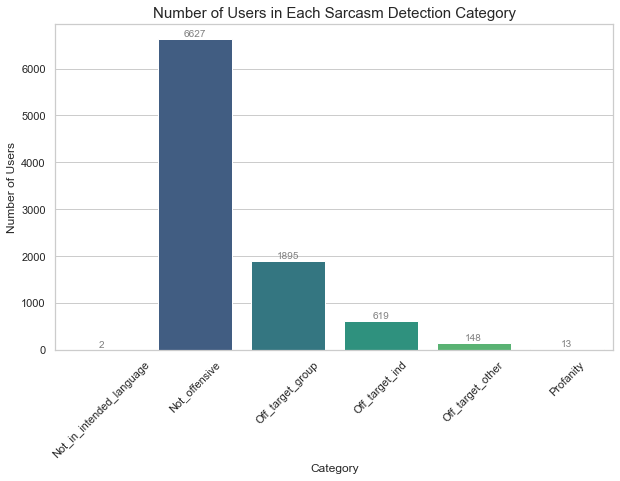

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Group by 'Sarcasm_Detected' and count unique 'OwnerUserId's in each group
user_counts = posts.groupby('Sarcasm_Detected')['OwnerUserId'].nunique()

# Enhancing the plot with Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=user_counts.index, y=user_counts.values, palette="viridis")
plt.xlabel('Category', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.title('Number of Users in Each Sarcasm Detection Category', fontsize=15)
plt.xticks(rotation=45)

# Adding the count above the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='gray', xytext=(0, 5),
                textcoords='offset points')

plt.show()




## NRE

In [ ]:
posts.columns

Index(['Id', 'PostTypeId', 'ParentId', 'AcceptedAnswerId', 'CreationDate',
       'Score', 'ViewCount', 'Body', 'OwnerUserId', 'LastActivityDate',
       'Title', 'Tags', 'AnswerCount', 'CommentCount', 'Vader_Compound',
       'Body_Cleaned', 'Sarcasm_Detected'],
      dtype='object')

In [ ]:
#  Combine the colums for better data 
posts['combined_text'] = posts['Title'] + ' ' + posts['Body_Cleaned']


In [ ]:
import pandas as pd
import spacy
nlp = spacy.load('en_core_web_sm')

In [ ]:
nlp = spacy.load('en_core_web_sm')
posts['named_entities'] = posts['combined_text'].apply(lambda text: [(ent.text, ent.label_) for ent in nlp(text).ents])


In [ ]:
print(posts['named_entities'].head())


0                                                                                                                                                                                                                                                                                                                                                                                                                                      [(UK, GPE), (UK, GPE), (decades, DATE), (six months, DATE), (US, GPE), (US, GPE)]
1                                                                                                                                                                                                                                                                                                                        [(Left, FAC), (Republicans, NORP), (Sanders, WORK_OF_ART), (Communist, NORP), (Fascist, ORG), (Democrats, NORP), (Trump, WORK_OF_ART), (Fascist, ORG), (Trump, WORK_OF_ART), (Communis

In [ ]:
from collections import Counter

def count_entities(entities_list):
    entity_counts = Counter()
    for entities in entities_list:
        entity_counts.update([ent[1] for ent in entities])  # Counting based on entity type
    return entity_counts

entity_counts = count_entities(posts['named_entities'])
print(entity_counts)


Counter({'GPE': 22065, 'ORG': 20243, 'PERSON': 10203, 'DATE': 9573, 'NORP': 9456, 'CARDINAL': 8843, 'ORDINAL': 2115, 'PERCENT': 1658, 'LOC': 1602, 'LAW': 1476, 'MONEY': 842, 'WORK_OF_ART': 769, 'EVENT': 650, 'PRODUCT': 496, 'TIME': 422, 'FAC': 303, 'LANGUAGE': 220, 'QUANTITY': 167})


In [ ]:
import plotly.express as px

entity_df = pd.DataFrame(entity_counts.items(), columns=['Entity', 'Count'])
fig = px.bar(entity_df, x='Entity', y='Count', title='Frequency of Named Entity Types')
fig.show()


Filtering by particular types of entities for example GPE for geopolitical entities or ORG for organisations

In [ ]:
def filter_entities(entities_list, entity_type):
    return [ent[0] for entities in entities_list for ent in entities if ent[1] == entity_type]

org_entities = filter_entities(posts['named_entities'], 'ORG')
print(org_entities[:10])  # Print first 10 organization 


['Fascist', 'Fascist', 'UBI', 'Murray', 'UBI', 'UBI', 'Social Security', 'Medicare', 'Medicaid', 'UBI']


Let's dive a bit deeper and see where such entities appear, for example we can try out with the United Nations organisation and see where and in which context it appears.

In [ ]:
def print_entity_context(df, entity):
    for _, row in df.iterrows():
        if any(ent[0] == entity for ent in row['named_entities']):
            print(row['combined_text']) 

print_entity_context(posts, 'United Nations')  


Comment: N/A Canada, especially between 1949 and 1982, was in a quite comparable relationship to London, if we don't count practicalities such as independent access to the sea and military strength.
Even today, the Queen of Canada reigns from abroad.  And yet, Canada is a sovereign country as much as a country can ever be.

Notes reflecting remarks by the OP and by JoelFan:

This answer focuses on whether the mere fact of a shared or non-resident head of state necessarily impacts the sovereignty of a nation.  The test I was applying was looking at what would likely happen during a constitutional crisis - a power clash between an unambiguously articulated will of the people of Andorra and the will of either Prince of Andorra.  It helped that Andorra is a democracy.  I could look at separation of powers, how the top ranks within each are constituted, on the process for constitutional amendments, and such.

Canada appealed to me as a measuring stick as both Canada and Andorra have been th